# Recreating the model from last time


Coefficients: 
 [ 2.46190922e+03 -1.04349224e+02  1.78708903e+00  2.03874245e+01
  4.14859782e+01]

Intercept: 
 575.6534165291897

R-squared:
0.9992794851996939


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


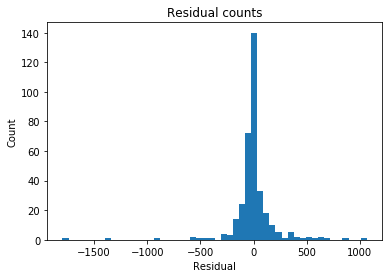

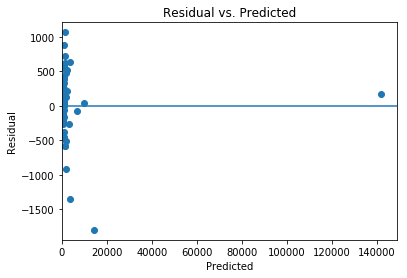

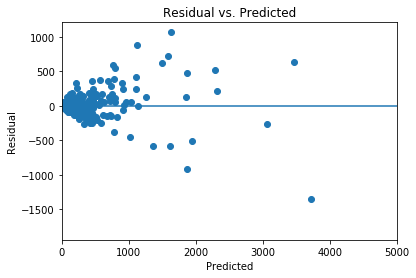

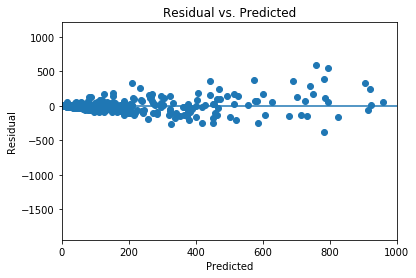

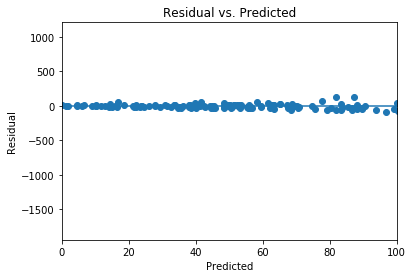

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model

fbi = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 ,skiprows=[1,2,3])

# data cleaning
fbi.columns = fbi.iloc[0]
fbi = fbi.drop(fbi.index[0])

# remove entirely NaN column
fbi = fbi.drop(fbi.columns[4], axis=1)
fbi.columns = ['city','population','violent_crime','murder','rape','robbery','agg_assault','property_crime','burglary','larceny','mv_theft','arson']

# stripping columns
fbi_obj = fbi.select_dtypes(['object'])
fbi[fbi_obj.columns] = fbi_obj.apply(lambda x: x.str.replace(',',''))

# delete reference rows at the bottom
fbi = fbi.drop(fbi.index[-3:])

# changing datatypes to numbers for all columns but city
for column in fbi:
    if column != 'city':
        fbi[column] = pd.to_numeric(fbi[column])

#PCA
sklearn_pca = PCA(n_components=10)
pca_feat = fbi.fillna(0).drop(['property_crime','city'],axis=1)
X = StandardScaler().fit_transform(pca_feat)
Y_sklearn = sklearn_pca.fit_transform(X)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))

# Creating the corresponding DF
fbi_pca = pd.DataFrame(Y_sklearn[:,0:2])
fbi_pca['property_crime'] = fbi['property_crime'].values.reshape(-1, 1)
fbi_pca.columns = ['component_1','component_2','property_crime']
fbi_pca.head()
        
# Adding population
percentile_divider = 25
fbi_pca['high_pop'] = np.where(fbi['population'] > np.percentile(fbi['population'],100-percentile_divider),1,0)
fbi_pca['low_pop'] = np.where(fbi['population'] < np.percentile(fbi['population'],percentile_divider),1,0)
fbi_pca['population'] = fbi['population'].values.reshape(-1,1)
fbi_pca['sqrt_population'] = np.sqrt(fbi_pca['population'])

# Creation of the model
regr = linear_model.LinearRegression()

X = fbi_pca[['component_1','component_2','sqrt_population','low_pop','high_pop']]
Y = fbi_pca['property_crime']


regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X)
actual = fbi_pca['property_crime']

# Calculate residuals
residual = actual - predicted
residual = pd.to_numeric(residual)

# Histogram of residuals
plt.hist(residual,bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

#Scatters
xlims = [(0,None),(0,5000),(0,1000),(0,100)]

for limit_tuple in xlims:
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.xlim(limit_tuple)
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

# Re-evaluating using cross validation

In [2]:
# Using sklearn to create different folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=3)

for train, test in kf.split(fbi_pca):
    regr = linear_model.LinearRegression()

    X = fbi_pca.iloc[train,:].loc[:,['component_1','component_2','sqrt_population','low_pop','high_pop']]
    Y = fbi_pca.iloc[train,:].loc[:,['property_crime']]

    regr.fit(X,Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))

    # Extract predicted values.
    predicted = regr.predict(fbi_pca.iloc[test,:].loc[:,['component_1','component_2','sqrt_population','low_pop','high_pop']]).flatten()
    actual = np.array(fbi_pca.iloc[test,:].loc[:,['property_crime']].iloc[:,0])
    
    from scipy import stats
    accuracy_measure = stats.pearsonr(actual,predicted)
    print('\nCorrelation between predicted and actual values: {}'.format(accuracy_measure))


Coefficients: 
 [[ 2.47970289e+03 -9.91220057e+01  1.42898919e+00  1.20954919e+00
   6.58991757e+01]]

Intercept: 
 [615.75848376]

R-squared:
0.9993537960022972

Correlation between predicted and actual values: (0.9391148447878984, 2.9003592657548547e-33)

Coefficients: 
 [[ 2.47559044e+03 -1.33175323e+02  1.49218579e+00  1.00236790e+01
   6.17389708e+01]]

Intercept: 
 [598.91724994]

R-squared:
0.9993469511459493

Correlation between predicted and actual values: (0.9957308072469476, 4.1794236525247646e-72)

Coefficients: 
 [[ 2.47008779e+03 -1.04870208e+02  1.61559778e+00  1.42727146e+01
   7.54806632e+01]]

Intercept: 
 [593.00264875]

R-squared:
0.9993781724672944

Correlation between predicted and actual values: (0.8700566185525893, 1.4232289442453827e-22)

Coefficients: 
 [[2496.11103446 -138.28982665    3.30131971   86.16008213 -110.23925145]]

Intercept: 
 [449.50777565]

R-squared:
0.9708603809934924

Correlation between predicted and actual values: (0.9997652304030439, 3.06

##### K Fold Evaluation
As you can see in the above, the data $r^2$ is consistent throughout our train/test folds and the correlation between predicted values and actuals is high. Let's see how it performs on new data.

# Testing it on another dataset

In [3]:
# Refit the model to the full fbi training set
regr = linear_model.LinearRegression()

X = fbi_pca[['component_1','component_2','sqrt_population','low_pop','high_pop']]
Y = fbi_pca['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X)
actual = fbi_pca['property_crime']


Coefficients: 
 [ 2.46190922e+03 -1.04349224e+02  1.78708903e+00  2.03874245e+01
  4.14859782e+01]

Intercept: 
 575.6534165291897

R-squared:
0.9992794851996939


In [4]:
# Import CA fbi_ca Data
fbi_ca = pd.read_csv("california.csv",skiprows=[1,2,3],error_bad_lines=False)

# data cleaning
fbi_ca.columns = fbi_ca.iloc[0]
fbi_ca = fbi_ca.drop(fbi_ca.index[0])

# remove entirely NaN column
fbi_ca = fbi_ca.drop(fbi_ca.columns[4], axis=1)
fbi_ca = fbi_ca.drop(fbi_ca.columns[12], axis=1)
fbi_ca.columns = ['city','population','violent_crime','murder','rape','robbery','agg_assault','property_crime','burglary','larceny','mv_theft','arson']

# stripping columns
fbi_ca_obj = fbi_ca.select_dtypes(['object'])
fbi_ca[fbi_ca_obj.columns] = fbi_ca_obj.apply(lambda x: x.str.replace(',',''))

# delete reference rows at the bottom
fbi_ca = fbi_ca.drop(fbi_ca.index[-3:])

# changing datatypes to numbers for all columns but city
for column in fbi_ca:
    if column != 'city':
        fbi_ca[column] = pd.to_numeric(fbi_ca[column])
        
#PCA
sklearn_pca = PCA(n_components=10)
pca_feat = fbi_ca.fillna(0).drop(['property_crime','city'],axis=1)
X = StandardScaler().fit_transform(pca_feat)
Y_sklearn = sklearn_pca.fit_transform(X)
var_ratios = (list(sklearn_pca.explained_variance_ratio_))
component_variances = (list(sklearn_pca.explained_variance_))

# Creating the corresponding DF
fbi_ca_pca = pd.DataFrame(Y_sklearn[:,0:2])
fbi_ca_pca['property_crime'] = fbi_ca['property_crime'].values.reshape(-1, 1)
fbi_ca_pca.columns = ['component_1','component_2','property_crime']
fbi_ca_pca.head()
        
# Adding population
percentile_divider = 25
fbi_ca_pca['high_pop'] = np.where(fbi_ca['population'] > np.percentile(fbi_ca['population'],100-percentile_divider),1,0)
fbi_ca_pca['low_pop'] = np.where(fbi_ca['population'] < np.percentile(fbi_ca['population'],percentile_divider),1,0)
fbi_ca_pca['population'] = fbi_ca['population'].values.reshape(-1,1)
fbi_ca_pca['sqrt_population'] = np.sqrt(fbi_ca_pca['population'])

# Making predictions
X = fbi_ca_pca[['component_1','component_2','sqrt_population','low_pop','high_pop']]

predicted_ca = regr.predict(X)
actual_ca = fbi_ca_pca['property_crime']
residual_ca = actual_ca - predicted_ca

from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(predicted_ca,actual_ca)
r_sqr = regr.score(X,actual_ca)

#rmse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_ca,predicted_ca)
rmse = np.sqrt(mse)

accuracy_measure = stats.pearsonr(actual_ca,predicted_ca)
print('\nCorrelation between predicted and actual values: {}'.format(accuracy_measure))
print('\nRoot Mean Squared Error: {:,}'.format(rmse))
print('\nR-Squared: {:.2f}'.format(r_sqr))


Correlation between predicted and actual values: (0.9818296243394578, 0.0)

Root Mean Squared Error: 2,796.170388951286

R-Squared: 0.73


Our model did an OK job, at least in terms of the correlation of predicted and actual values, as well as r-squared. However, the mean-squared error is still pretty big. As we can see from the plots below, it seems to be suffering from some heteroscedasticity, wherein the low-end is being underpredicted and the high-end is being overpredicted. Let's add a metric for crime per population and see if we can make this a bit more accurate.

In [5]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_ca,predicted_ca)
np.sqrt(mse)

2796.170388951286

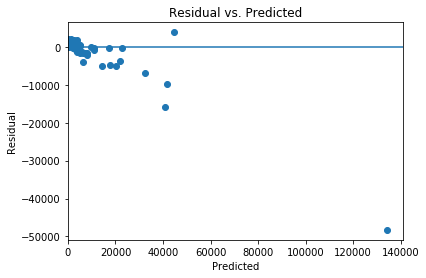

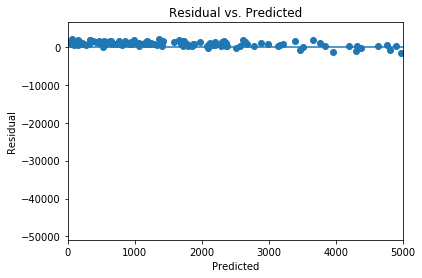

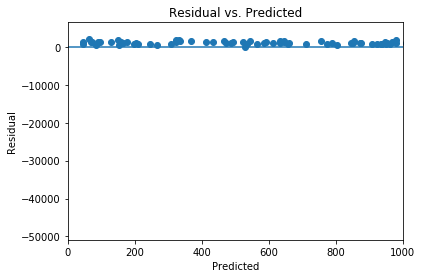

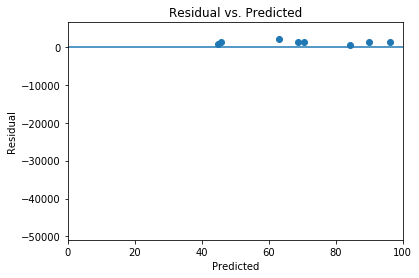

In [6]:
#Scatters
xlims = [(0,None),(0,5000),(0,1000),(0,100)]

for limit_tuple in xlims:
    plt.scatter(predicted_ca, residual_ca)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.xlim(limit_tuple)
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

In [7]:
# Creating the new metric, which is a measure of the sum of all other crimes divided by population.
# We won't include arson in total crime since it has many null values in the original data set
sum_crimes = np.array(fbi[['violent_crime','murder','rape','robbery','agg_assault','burglary','larceny','mv_theft']].sum(axis=1))
fbi_pca['crime_per_person'] = sum_crimes[:] / fbi_pca['population']
fbi_pca.head()

,component_1,component_2,property_crime,high_pop,low_pop,population,sqrt_population,crime_per_person
0,-0.269159,-0.124666,12,0,1,1861,43.139309,0.006448
1,-0.265973,-0.124845,24,0,1,2577,50.764161,0.011641
2,-0.267582,-0.125068,16,0,1,2846,53.347915,0.007730
3,0.923785,-0.096983,4090,1,0,97956,312.979233,0.057904
4,-0.211496,-0.121533,223,0,0,6388,79.924965,0.042110


In [8]:
# Using sklearn to create different folds
for train, test in kf.split(fbi_pca):
    regr = linear_model.LinearRegression()

    X = fbi_pca.iloc[train,:].loc[:,['component_1','component_2','sqrt_population','low_pop','high_pop','crime_per_person']]
    Y = fbi_pca.iloc[train,:].loc[:,['property_crime']]

    regr.fit(X,Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))

    # Extract predicted values.
    predicted = regr.predict(fbi_pca.iloc[test,:].loc[:,['component_1','component_2','sqrt_population','low_pop','high_pop','crime_per_person']]).flatten()
    actual = np.array(fbi_pca.iloc[test,:].loc[:,['property_crime']].iloc[:,0])
    
    from scipy import stats
    accuracy_measure = stats.pearsonr(actual,predicted)
    print('\nCorrelation between predicted and actual values: {}'.format(accuracy_measure))


Coefficients: 
 [[ 2.48190378e+03 -1.08287872e+02  1.36643941e+00  1.09775840e+01
   6.32614634e+01  2.88712667e+03]]

Intercept: 
 [555.37702133]

R-squared:
0.9993853071916248

Correlation between predicted and actual values: (0.9405459801955786, 1.3227534200984922e-33)

Coefficients: 
 [[ 2.47343603e+03 -1.49257846e+02  1.51611202e+00  2.12747900e+01
   5.41996075e+01  2.28620984e+03]]

Intercept: 
 [544.00606494]

R-squared:
0.9993654551184308

Correlation between predicted and actual values: (0.9972354357763248, 1.6411906211637314e-78)

Coefficients: 
 [[ 2.47053602e+03 -1.14687252e+02  1.58916199e+00  2.88634203e+01
   6.91028101e+01  2.84668778e+03]]

Intercept: 
 [528.43350058]

R-squared:
0.999410062167799

Correlation between predicted and actual values: (0.8802048514113255, 1.0656850780369754e-23)

Coefficients: 
 [[2225.60140712  -87.26852822    3.76028608  120.86363363 -122.65542145
  3599.11609156]]

Intercept: 
 [268.43811651]

R-squared:
0.9753701328039733

Correlation

The model performed just about as well on our folds. Let's see how it does with the CA data.

In [9]:
# Refit the model to the full fbi training set
regr = linear_model.LinearRegression()

X = fbi_pca[['component_1','component_2','sqrt_population','low_pop','high_pop','crime_per_person']]
Y = fbi_pca['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X)
actual = fbi_pca['property_crime']


Coefficients: 
 [ 2.46198256e+03 -1.14310660e+02  1.76697301e+00  3.45666888e+01
  3.53586717e+01  2.81514849e+03]

Intercept: 
 512.4314298988502

R-squared:
0.9993157766982249


In [10]:
# Creating new variable for CA
sum_crimes = np.array(fbi_ca[['violent_crime','murder','rape','robbery','agg_assault','burglary','larceny','mv_theft']].sum(axis=1))
fbi_ca_pca['crime_per_person'] = sum_crimes[:] / fbi_ca_pca['population']
fbi_ca_pca.head(20)

,component_1,component_2,property_crime,high_pop,low_pop,population,sqrt_population,crime_per_person
0,-0.258152,-0.109692,886,0,0,31165,176.536115,0.041136
1,-0.765553,-0.112126,306,0,0,20762,144.090249,0.016569
2,-0.192693,-0.076571,1902,1,0,76206,276.054342,0.029105
3,-0.731567,-0.064844,557,0,0,19104,138.217220,0.032192
4,-0.223732,-0.034656,1774,1,0,84710,291.049824,0.024790
5,-0.737854,-0.140161,315,0,0,50005,223.617978,0.007299
6,-0.820975,-0.055729,71,0,1,2681,51.778374,0.047370
7,-0.722171,-0.037236,510,0,0,20068,141.661569,0.030795
8,3.228056,0.201037,9611,1,0,345320,587.639345,0.034377
9,-0.636064,-0.033085,721,0,1,10098,100.488805,0.083878



Correlation between predicted and actual values: (0.9773037040523324, 1.6643064958706e-311)

Root Mean Squared Error: 2,863.753044666857

R-Squared: 0.72


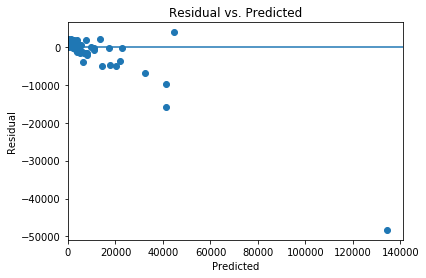

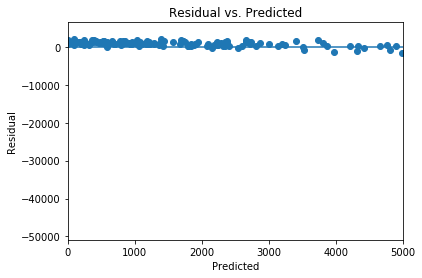

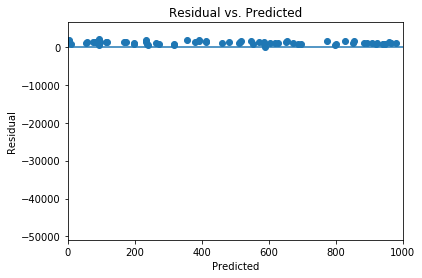

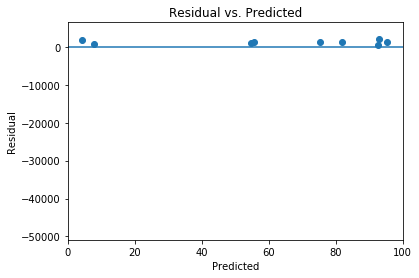

In [12]:
# Making predictions on CA data
X = fbi_ca_pca[['component_1','component_2','sqrt_population','low_pop','high_pop','crime_per_person']]

predicted_ca = regr.predict(X)
actual_ca = fbi_ca_pca['property_crime']
residual = actual - predicted

from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(predicted_ca,actual_ca)
r_sqr = regr.score(X,actual_ca)

#rmse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual_ca,predicted_ca)
rmse = np.sqrt(mse)

accuracy_measure = stats.pearsonr(actual_ca,predicted_ca)
print('\nCorrelation between predicted and actual values: {}'.format(accuracy_measure))
print('\nRoot Mean Squared Error: {:,}'.format(rmse))
print('\nR-Squared: {:.2f}'.format(r_sqr))

#Scatters
xlims = [(0,None),(0,5000),(0,1000),(0,100)]

for limit_tuple in xlims:
    plt.scatter(predicted_ca, residual_ca)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.xlim(limit_tuple)
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

All three measures of model accuracy are about the same. There may be other avenues for improving the model we could consider, such as paring down the features to make the model more generalizable, or perhaps there are some other fundamental differences between CA and NY that we'd need to investigate. For example, perhaps there is more property crime because there are much more single home dwellings in California than New York, in which there are some denser towns or cities with more apartments?